In [5]:
# Importing the relevant python libraries for FFT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from numpy.fft import fft, ifft, fftfreq, fftshift

In [8]:
def find_freqs(V, sample_rate, M):

    ''' 
    Returns a series of frequencies ordered by energy density. 
    As the function deals with music notes, it skips 3 Hz, so that noise is not counnted twice. 
    
    Parameters
    -----------
    V: discrete signal

    sample_rate: rate of sampling
    
    M: number of frequencies to be returned


    -----------
    '''
    N = len(V)

    # Getting total time of the audio
    tN = N / sample_rate

    #Getting the frequencies
    n = np.arange(-N/2,N/2,1)
    f = n / tN  
    
    # calculate the Fourier transform of V
    V_fft = fft(V, norm ='forward')

    #Calculate energy spectral density. Analytically we don't need to use the np.real function, but there are computational errors in handling variables
    S_n = np.real(V_fft * np.conjugate(V_fft))
    

    # We take only the positive frequencies here
    half_freq = int(len(f)/2)
    positive_f = f[half_freq:]
    
    # We shift to the zero frequency and then take only the energy densities corresponding to the positive frequencies
    positive_Sn = fftshift(S_n)[half_freq:] 
    peaks = np.empty(shape = (0,2))
    old_Sn = 0
    index = 0
    
    while index < len(positive_Sn):
        Sn = positive_Sn[index]
        if Sn > old_Sn:
            if Sn > positive_Sn[index+1] and Sn > positive_Sn[index+3]  and Sn > positive_Sn[index+7] and Sn > positive_Sn[index+11] and Sn > positive_Sn[index+15]:
            
                peaks = np.concatenate([peaks, [[Sn, positive_f[index]]]], axis=0)
                old_Sn = 0
                index += 20 # Skip 3.3 Hz
                if index > len(positive_Sn) - 23:
                    break
            else:
                index += 1
            
        else:
            old_Sn = Sn
            index += 1
    

    import pandas as pd

    df_peaks = pd.DataFrame(peaks, columns = ["Sn", "frequency / Hz"])
    sorted = df_peaks.sort_values(by="Sn", ascending= False)

    
    return sorted["frequency / Hz"].head(M)
  

In [10]:
def find_notes(V,sample_rate, M):
    
    ''' 
    Returns arrays of notes, their octaves and frequency, It calls the find_freqs() function. 
    This function has a nested function to find the note of each frequency, note_finder()
    Parameters
    -----------
    V: discrete signal

    sample_rate: rate of sampling
    
    M: number of frequencies to be returned

    -----------
    '''
    
    def note_finder(frequency):

        '''

        Finds note and octave of a particular frequency.

        '''
        
        notes = {16.35: 'C',17.32: 'C#',18.35: 'D', 19.45: 'D#', 20.60: 'E',21.83: 'F', 23.12: 'F#', 24.50: 'G', 25.96: 'G#',27.50: 'A',
                 29.14: 'A#',30.87: 'B'}
        octaves = [0,1,2,3,4,5,6,7]
        old_note = 16.35
    
        for octave in octaves:
            for note in notes:
                note = note *2**octave
                if frequency < note:
                    if abs(note-frequency) < abs(old_note - frequency):
             
                        return notes[note/2**octave], octave
                    else:

                        return notes[old_note/2**old_octave], old_octave
                    
              
                
                else:
                    old_octave = octave
                    old_note = note
    
  
    frequencies = find_freqs(V, sample_rate= sample_rate, M = M)
    notes = np.empty(shape = (0,3))
    for frequency in frequencies:
        note,octave= note_finder(frequency)
        notes= np.concatenate([notes, [[note, octave,frequency]]], axis=0)
    return notes
        


In [11]:
def identify_chord(path_file_audio, path_file_csv):

    samplerate, V_chord = wavfile.read(path_file_audio) #Discrete sample

    found_notes = find_notes(V_chord, samplerate,M = 3) # Find the notes
    
    notes = [] # Empty list that will contain the notes exctracted from found_notes()
    
    for note in found_notes: # Putting the notes into a list 
        notes.append(note[0])

    major_chords = pd.read_csv(path_file_csv) #DataFrame object containing chords
    
    for i in range(len(major_chords)):
        if sorted(notes) == sorted(major_chords.loc[i][["note1","note2","note3"]].values):
            return major_chords.loc[i]["chord"]                          #Return the major chord found

    #If nothing is found this message will be returned instead
    return "No major chord identified"
    


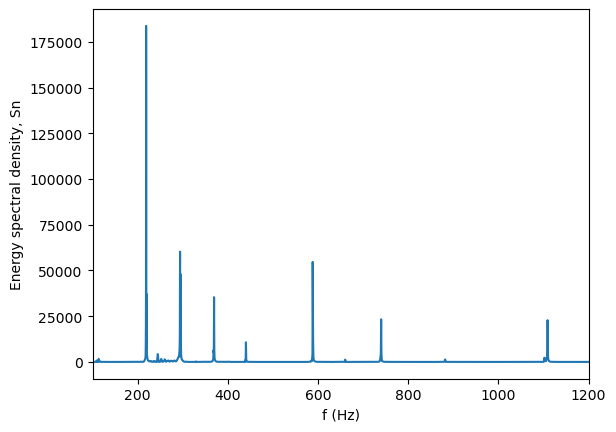

In [12]:
#Guitar D chord audio signal

samplerate, V = wavfile.read('audio_signals/guitar-Dchord.wav')
tN = len(V) / samplerate
N = len(V)

# calculate the Fourier transform of V
V_fft = fft(V, norm ='forward')

#Calculate energy spectral density. Analytically we don't need to use the np.real function, but there are computational errors in handling variables

S_n = np.real(V_fft * np.conjugate(V_fft))

n = np.arange(-N/2,N/2,1)

f = n / tN  

plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(100,1200);

In [13]:
find_freqs(V, samplerate, 6)

44      218.860035
55      294.124120
115     588.248239
71      369.553257
145     740.096831
220    1109.154930
Name: frequency / Hz, dtype: float64

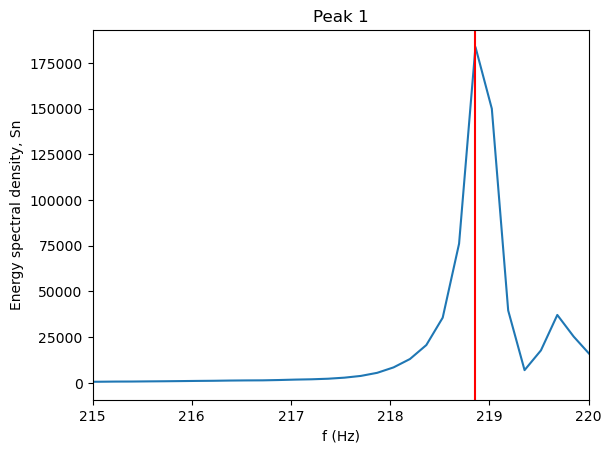

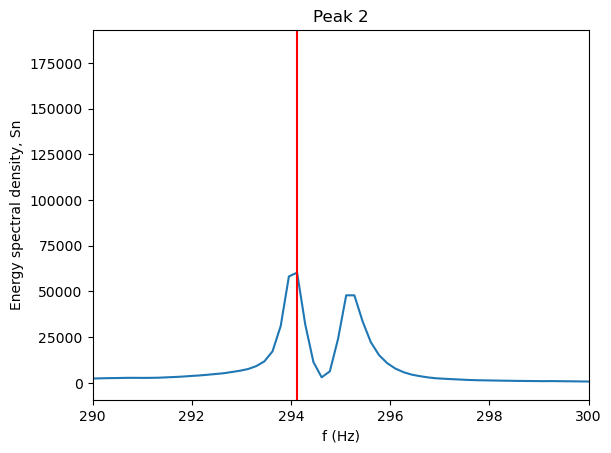

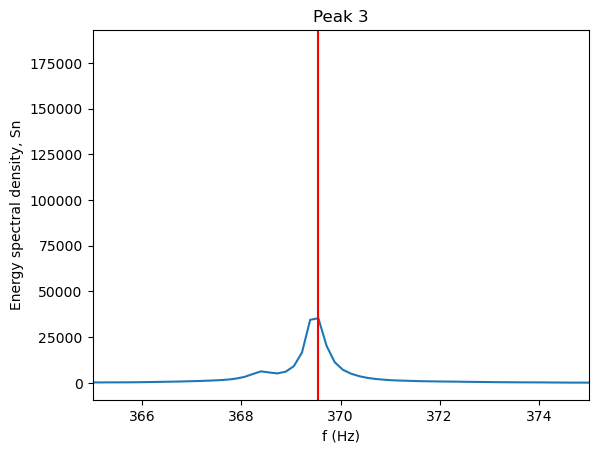

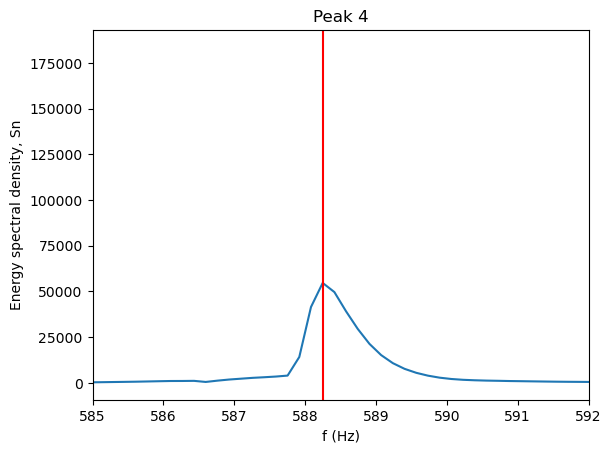

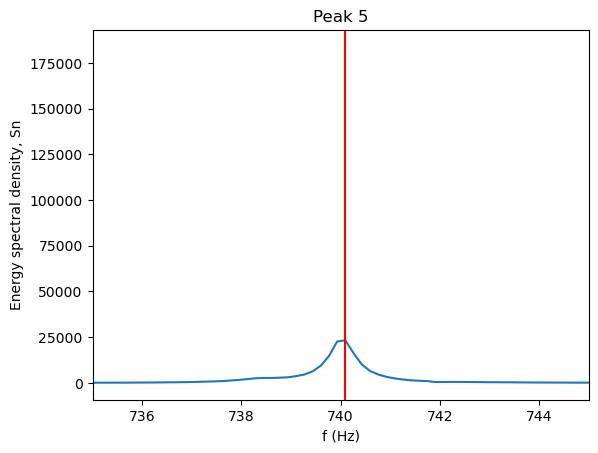

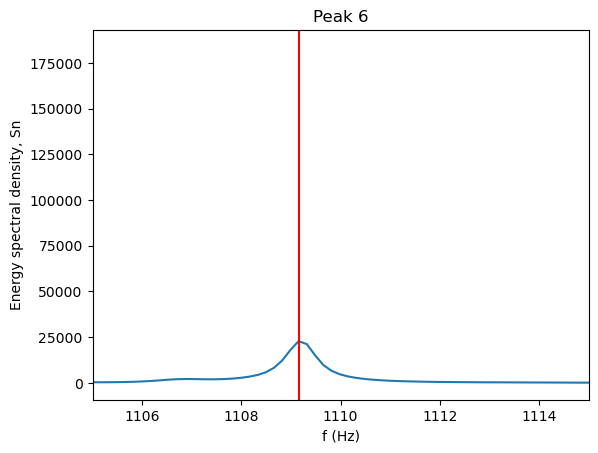

In [14]:
peak1, peak2, peak3, peak4, peak5, peak6 = find_freqs(V,samplerate, 6)
# We have 6 positive frequencies, we are going to plot and find the frequency of all these peaks now.
plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(215,220)
plt.axvline(peak1, color = "red")
plt.title("Peak 1")
plt.show();


plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(290,300)
plt.axvline(peak2, color = "red")
plt.title("Peak 2")
plt.show();

plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(365,375)
plt.axvline(peak4, color = "red")
plt.title("Peak 3")
plt.show();

plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(585,592)
plt.axvline(peak3, color = "red")
plt.title("Peak 4")
plt.show();

plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(735,745)
plt.axvline(peak5, color = "red")
plt.title("Peak 5")
plt.show();

plt.plot(f, fftshift(S_n))
plt.xlabel('f (Hz)')
plt.ylabel('Energy spectral density, Sn')
plt.xlim(1105,1115)
plt.axvline(peak6, color = "red")
plt.title("Peak 6")
plt.show();

In [15]:
find_notes(V,samplerate, 6)  

array([['A', '3', '218.86003521126761'],
       ['D', '4', '294.1241197183099'],
       ['D', '5', '588.2482394366198'],
       ['F#', '4', '369.55325704225356'],
       ['F#', '5', '740.0968309859155'],
       ['C#', '6', '1109.1549295774648']], dtype='<U32')

In [16]:
samplerate1, V_chord1 = wavfile.read('audio_signals//chord1.wav')
samplerate2, V_chord2 = wavfile.read('audio_signals//chord2.wav')
samplerate3, V_chord3 = wavfile.read('audio_signals//chord3.wav')

In [18]:
chord1 = identify_chord(path_file_audio= "audio_signals//chord1.wav", path_file_csv= "major_chords.csv")
chord1

'No major chord identified'

In [20]:
chord2 = identify_chord(path_file_audio= "audio_signals//chord2.wav", path_file_csv= "major_chords.csv")
chord2

'E'

In [21]:
chord3 = identify_chord(path_file_audio= "audio_signals//chord3.wav", path_file_csv= "major_chords.csv")
chord3

'G'